# __Predicting Customer Churn__
#### Project by Nikolas White

### __Data Collection/Cleaning__

In [3]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Drop customerID column as it's not useful for our analysis
df.drop('customerID', axis=1, inplace=True)

# Convert TotalCharges to numeric, setting errors='coerce' will replace non-numeric values with NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill missing values in TotalCharges with the median value
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Convert 'SeniorCitizen' from integer to categorical
df['SeniorCitizen'] = df['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

# Replace 'No internet service' and 'No phone service' with 'No' for simplicity
replace_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies', 'MultipleLines']
for col in replace_cols:
    df[col] = df[col].replace({'No internet service': 'No', 'No phone service': 'No'})

# Convert binary columns to 0 and 1
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn', 'SeniorCitizen']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

# One-hot encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Save cleaned data to a new CSV file
df.to_csv('cleaned_telco_customer_churn.csv', index=False)


### __Exploratory Data Analysis__

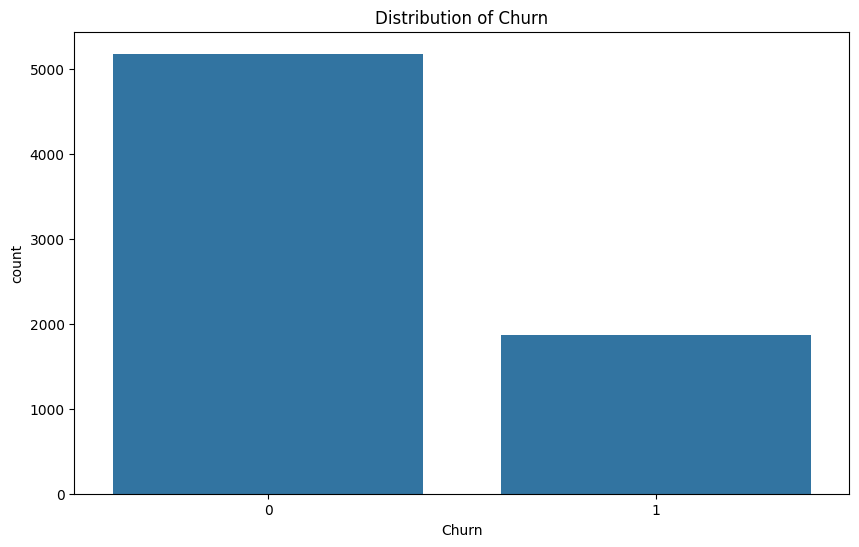

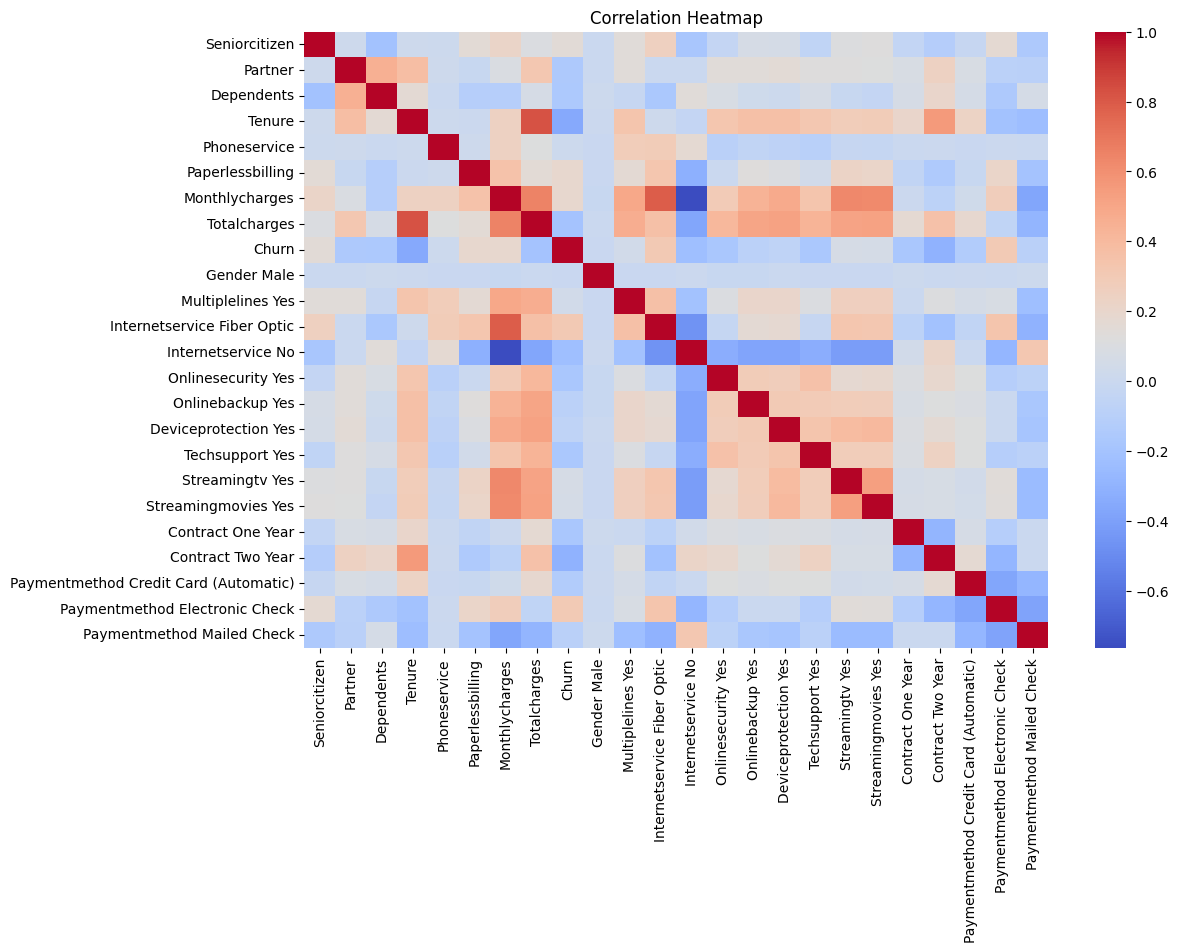

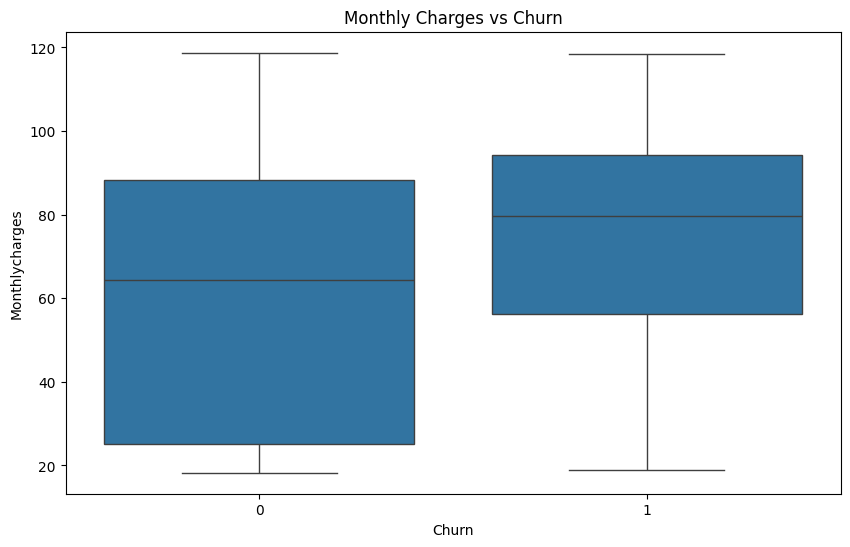

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load the cleaned dataset
df = pd.read_csv('cleaned_telco_customer_churn.csv')

# Capitalize all feature names and replace underscores with spaces
df.columns = [col.replace('_', ' ').title() for col in df.columns]

# Distribution of Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.savefig('distribution_of_churn.png')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

# Boxplot for MonthlyCharges and Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='Monthlycharges', data=df)
plt.title('Monthly Charges vs Churn')
plt.savefig('monthly_charges_vs_churn.png')
plt.show()


### __Model Building__

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Load the cleaned dataset
df = pd.read_csv('cleaned_telco_customer_churn.csv')

# Remove highly correlated features
df.drop(['TotalCharges'], axis=1, inplace=True)

# Capitalize all feature names
df.columns = [col.capitalize() for col in df.columns]

# Define features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert the scaled arrays back to DataFrames to maintain feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)

# Save feature engineered data
X_train_scaled.to_csv('X_train_scaled.csv', index=False)
X_test_scaled.to_csv('X_test_scaled.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

### __Model Interpretation__

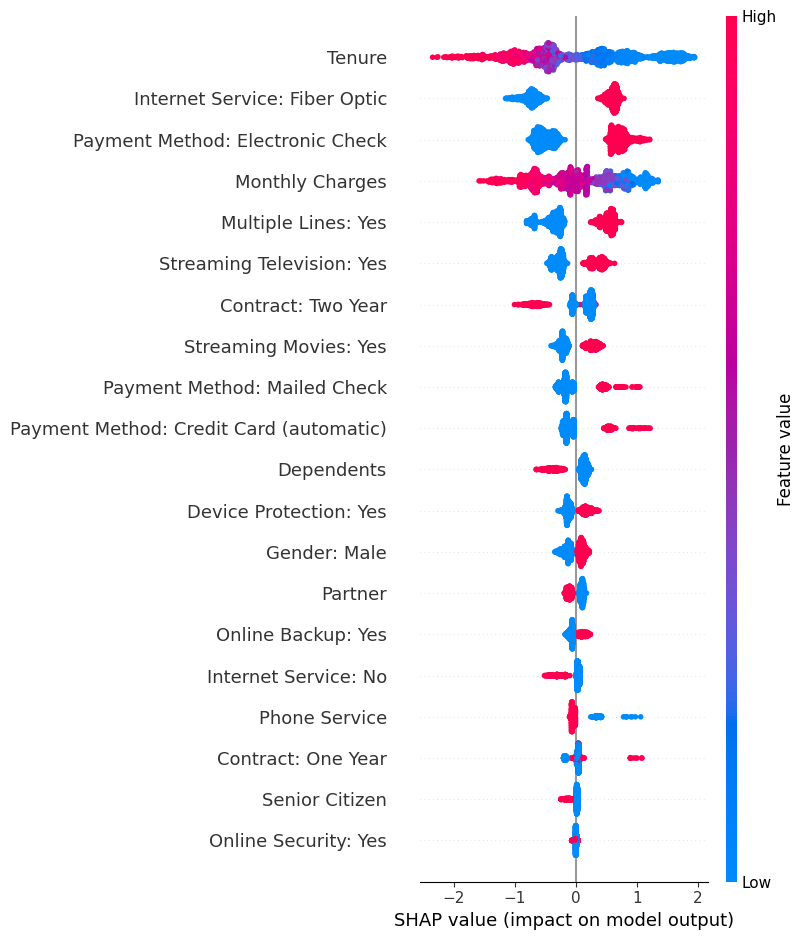

In [12]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier

# Function to format column names
def format_column_names(columns):
    formatted_columns = []
    for col in columns:
        col = col.replace('_', ' ').title()
        col = col.replace('Internetservice', 'Internet Service:') \
                 .replace('Monthlycharges', 'Monthly Charges') \
                 .replace('Paymentmethod', 'Payment Method:') \
                 .replace('Streamingmovies', 'Streaming Movies:') \
                 .replace('Paperlessbilling', 'Paperless Billing') \
                 .replace('Onlinesecurity', 'Online Security:') \
                 .replace('Multiplelines', 'Multiple Lines:') \
                 .replace('Techsupport', 'Tech Support:') \
                 .replace('Streamingtv', 'Streaming Television:') \
                 .replace('Phoneservice', 'Phone Service') \
                 .replace('Seniorcitizen', 'Senior Citizen') \
                 .replace('Onlinebackup', 'Online Backup:') \
                 .replace('Gender', 'Gender:') \
                 .replace('Deviceprotection', 'Device Protection:') \
                 .replace('Contract', 'Contract:') \
                 
        formatted_columns.append(' '.join([word.capitalize() for word in col.split()]))
    return formatted_columns

# Load the scaled data with original feature names
X_train_scaled = pd.read_csv('X_train_scaled.csv')
X_test_scaled = pd.read_csv('X_test_scaled.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()

# Update feature names
X_train_scaled.columns = format_column_names(X_train_scaled.columns)
X_test_scaled.columns = format_column_names(X_test_scaled.columns)

# Load the Gradient Boosting
best_model = GradientBoostingClassifier()
best_model.fit(X_train_scaled, y_train)

# Explain the model's predictions using SHAP
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_test_scaled, check_additivity=False)

# Plot SHAP values and save the plot as a PNG file
plt.figure()
shap.summary_plot(shap_values, X_test_scaled, show=False)
plt.savefig('shap_summary_plot.png')
plt.show()


### __Key Takeaways__

1. **Tenure**. Longer tenure significantly reduces the likelihood of churn. Customers who have been with the company for a longer period are more likely to stay.

2. **Internet Service: Fiber Optic**. Customers using fiber optic internet service are more likely to churn compared to those using other types of internet services.

3. **Payment Method: Electronic Check**. Customers who use electronic checks as their payment method exhibit a higher propensity to churn.

4. **Monthly Charges**. Higher monthly charges are associated with an increased likelihood of churn. This indicates that cost-sensitive customers are more likely to leave.

5. **Multiple Lines: Yes**. Customers with multiple lines are more likely to churn, suggesting potential issues with service quality or pricing for multiple line subscriptions.

6. **Streaming Services (Television and Movies)**. Access to streaming services like streaming television and movies is associated with higher churn. This could be due to competition or dissatisfaction with the service.

7. **Contract Two Year**. Customers with two-year contracts are less likely to churn, indicating that long-term contracts can help in retaining customers.

8. **Payment Method: Mailed Check and Credit Card (Automatic)**. These payment methods are associated with lower churn rates, suggesting that customers using these methods may be more stable or satisfied.

9. **Dependents and Device Protection**. These factors show some impact on churn, but less significant compared to the above factors.


### __Business Implications__

1. **Customer Retention Programs**. Develop retention programs focused on customers with shorter tenure to extend their stay with the company. Encourage new customers to sign up for longer-term contracts with benefits and discounts, as these customers are less likely to churn.

2. **Service Improvement for Fiber Optic Customers**. Focus on improving the quality and reliability of fiber optic internet services to reduce churn among these high-risk customers. Collect and act on feedback specifically from fiber optic users to address their concerns.

3. **Pricing Strategy**. Consider revising pricing plans to make them more competitive, especially for customers with higher monthly charges. Offer more flexible payment options and discounts for electronic check users to lower their churn risk.

4. **Multiple Lines and Streaming Services**. Create attractive bundle offers for customers with multiple lines and streaming services to enhance value and satisfaction. Invest in improving the streaming service experience to address potential dissatisfaction.

5. **Payment Method Optimization**. Encourage the use of mailed checks and automatic credit card payments by offering incentives, as these methods are associated with lower churn.

6. **Personalized Customer Engagement**. While these factors have lower impact, personalized engagement strategies can still be developed to cater to these customer segments.